# Coding Tutorial 3: Monitoring Training and Regularization

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```


## Overview

Sections:
- Multi-class classification
- Monitoring training with learning curves
- Early stopping
- L2 regularization

Objectives:
- Learn how to plot the learning curves side by side
- Learn how to diagnose model training issues
- Learn how to perform early stopping to mitigate overfitting and to, more generally, save and load checkpoints
- Learn how to use an L2 penalty norm to mitigate overfitting

In [1]:
!pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics

## Multi-Class Classification

In the previous coding tutorial, we learned to build and train a binary classification model. Today, we will practice how to handle **multi-class** classification.

### Four-Class Classification Dataset

- `x` has two features $(X_1, X_2)$
- `y` indicates the class number $Y$, where
  - $Y = 0$ if $X_1$ ***between*** the range $0.3$ and $0.8$ and $X_2$ ***between*** the range $0.3$ and $0.8$
  - $Y = 1$ if $X_1$ ***between*** the range $0.3$ and $0.8$ and $X_2$ ***outside*** the range $0.3$ and $0.8$
  - $Y = 2$ if $X_1$ ***outside*** the range $0.3$ and $0.8$ and $X_2$ ***between*** the range $0.3$ and $0.8$
  - $Y = 3$ if $X_1$ ***outside*** the range $0.3$ and $0.8$ and $X_2$ ***outside*** the range $0.3$ and $0.8$

There are **four** classes in this dataset.

In [3]:
num_samples = 200
num_features = 2
x = torch.rand(num_samples, num_features)

# create data rule
def calculate_label(x_data):
  if x_data[0] < 0.3 or x_data[0] > 0.8:
    if x_data[1]  < 0.3 or x_data[1] > 0.8:
      label = 0
    else:
      label = 1
  else:
    if x_data[1]  < 0.3 or x_data[1] > 0.8:
      label = 2
    else:
      label = 3
  return label

# add a small noise to x before assigning classes
x_noisy = x + 0.01*torch.rand(num_samples, num_features)
y = torch.tensor([calculate_label(sample) for sample in x_noisy], dtype=torch.long)

x_train = x[:int(len(x)*0.5)].to("cuda")
y_train = y[:int(len(x)*0.5)].to("cuda")
x_test = x[int(len(x)*0.5):].to("cuda")
y_test = y[int(len(x)*0.5):].to("cuda")

print('Training input size: {}, output size: {}'.format(x_train.shape, y_train.shape))
print('Testing input size: {}, output size: {}'.format(x_test.shape, y_test.shape))


Training input size: torch.Size([100, 2]), output size: torch.Size([100])
Testing input size: torch.Size([100, 2]), output size: torch.Size([100])


Let's adopt the model structure from `MLPBinaryClassifier` with the following changes:
- Remove the final `nn.Sigmoid` layer
- Add an argument `output_size` to match our multi-class setting

**Discussion**

Why isn't there a softmax layer applied to the final linear output?

The **Cross Entropy Loss** function we use to train this model applies softmax, so we don't need another softmax layer here. The output of this model will be the size of classes (i.e., 4 in our example).

### Multi-Class MLP Classifier

In [4]:
class MLPMultiClassClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPMultiClassClassifier, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.linear1 = nn.Linear(self.input_size, hidden_size)
    self.activation1 = nn.Sigmoid()
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.activation2 = nn.Sigmoid()
    self.linear3 = nn.Linear(hidden_size, self.output_size)

  def forward(self, x):
    linear1 = self.linear1(x)
    act1 = self.activation1(linear1)
    linear2 = self.linear2(act1)
    act2 = self.activation2(linear2)
    output = self.linear3(act2)
    return output

To train the model, use the Cross Entropy Loss [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
```
loss_function = nn.CrossEntropyLoss()
```
By design, the model output has multiple nodes (i.e., 4). Therefore, the output `logits` will be in `(sample_size, 4)` shape. Since the softmax function is applied in the loss function, the output loss will be in `(sample_size, 1)` shape.
```
logits = model(x_train)
loss = loss_function(logits, y_train)
```
We will practice these steps later when training the model.

## Monitoring Training

Underfitting and overfitting are common issues in training. Before learning how to fix these issues, we need to learn how to **recognize** them from learning curves. Helpful visualizations are the following:
- Training loss vs. test loss
- Training performance vs. test performance (e.g., accuracy)

### Visualization Tool



We'll be visualizing the loss and accuracy plots to monitor the training. Recall that `matplotlib` is a common visualization tool in deep learning coding. Today, we will practice the advance method in plotting, which is `subplots`. The `subplots()` method allows us to create multiple plots in one figure.

We will use `ax[index]` to manage each subplot. The rest of the settings are similar. For instance, in a single plot we use `plt.xlabel('x-axis label')` to determine the label for x axis, and in the subplot we use `ax[index].set_xlabel('x-axis label')` for the same purpose.

If you forgot about how to use the library `matplotlib.pyplot`, see the [documentation](https://matplotlib.org/stable/api/pyplot_summary.html) and revisit Coding Tutorial 2!

In [5]:
import matplotlib.pyplot as plt

def plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test):
  # Create a figure and subplots
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

  # Plot Loss on the first subplot
  ax[0].plot(epochs, losses_train, label='Train set loss')
  ax[0].plot(epochs, losses_test, label='Test set loss')
  ax[0].set_title('Training Loss Over Epochs')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].grid(True)
  ax[0].legend()

  # Plot Accuracy on the second subplot
  ax[1].plot(epochs, acc_train, label='Train set accuracy')
  ax[1].plot(epochs, acc_test, label='Test set accuracy')
  ax[1].set_title('Training Accuracy Over Epochs')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

Let's test out this function! It's suppose to make two side-by-side subplots, where `loss plot` is on the left and `accurarcy plot` is on the right. Pass in some toy values and see the plots.

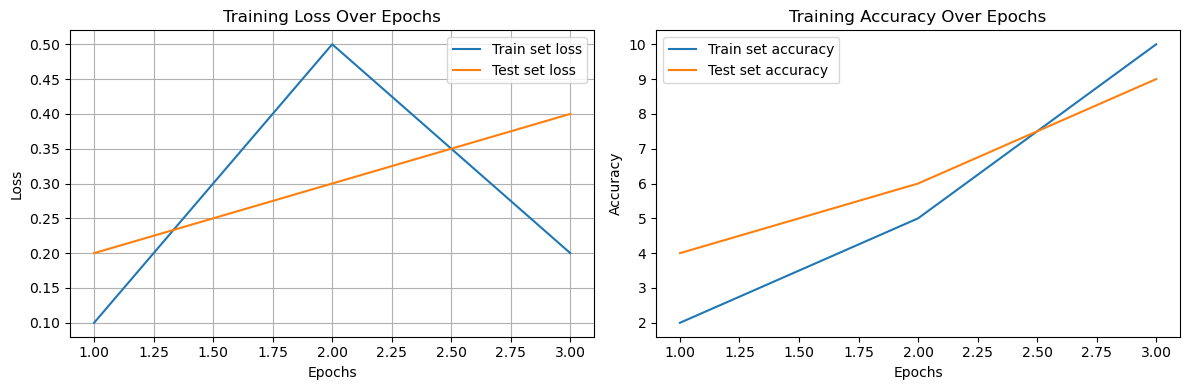

In [6]:
epochs = [1, 2, 3]
losses_train = [0.1, 0.5, 0.2]
losses_test = [0.2, 0.3, 0.4]
acc_train = [2, 5, 10]
acc_test = [4, 6, 9]
plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test)

### Underfitting

A common way to diaganose underfitting is to compare training and validation performance. If both are low, it’s a sign of underfitting.

There can be many reasons for underfitting, for instance,
- model complexity too low
- training set too small
- not enough epochs used for

To understand what the problem is, we can tweak these settings and see if there's improvement.



For instance, what happens when we set `hidden_size = 2` versus `hidden_size = 4` for the model.




Epoch 1000/10000, loss: 0.5712, acc train (%): 78.00
Epoch 2000/10000, loss: 0.0993, acc train (%): 98.00
Epoch 3000/10000, loss: 0.0221, acc train (%): 100.00
Epoch 4000/10000, loss: 0.0112, acc train (%): 100.00
Epoch 5000/10000, loss: 0.0073, acc train (%): 100.00
Epoch 6000/10000, loss: 0.0053, acc train (%): 100.00
Epoch 7000/10000, loss: 0.0041, acc train (%): 100.00
Epoch 8000/10000, loss: 0.0033, acc train (%): 100.00
Epoch 9000/10000, loss: 0.0028, acc train (%): 100.00
Epoch 10000/10000, loss: 0.0024, acc train (%): 100.00


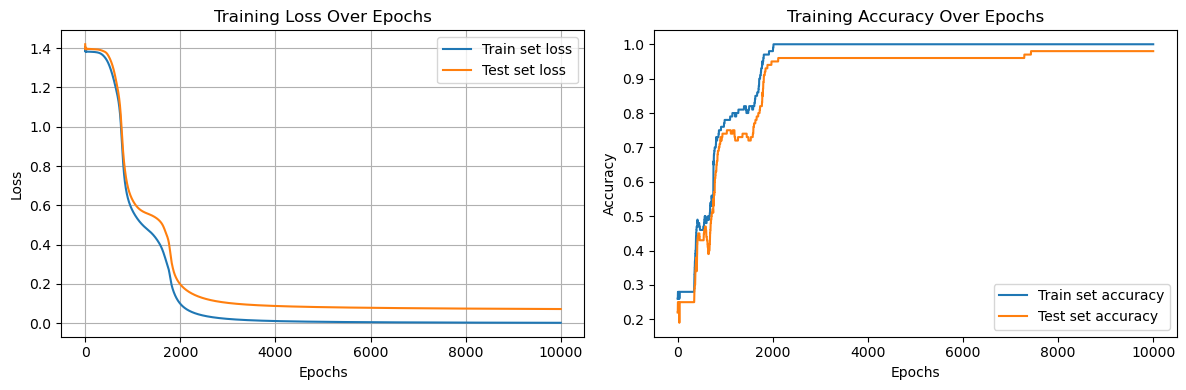

In [7]:
# Create the model
hidden_size = 4
num_classes = 4
model = MLPMultiClassClassifier(input_size=num_features, hidden_size=hidden_size, output_size=num_classes).to("cuda")

# Define loss function optimizer, and metric
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=4).to("cuda")

# Start training
num_epochs = 10000
epochs = []
losses_train = []
losses_test = []
acc_train = []
acc_test = []
for epoch in range(num_epochs):
    model.train()

    # forward and backpropagation on train
    logits = model(x_train)
    loss = loss_function(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute train loss and acc
    train_loss = loss.item()
    predicted_classes = torch.argmax(logits, dim=1)
    train_acc = accuracy_metric(predicted_classes, y_train)

    # compute test loss and acc
    logits = model(x_test)
    test_loss = loss_function(logits, y_test).item()
    predicted_classes = torch.argmax(logits, dim=1)
    test_acc = accuracy_metric(predicted_classes, y_test)

    # print loss and accuracy every n (=20) epochs
    if epoch % 1000 == 999:
        print('Epoch {}/{}, loss: {:.4f}, acc train (%): {:.2f}'.format(epoch+1, num_epochs, train_loss, train_acc*100))

    # Save loss and accuracy
    epochs.append(epoch)
    losses_train.append(train_loss)
    acc_train.append(train_acc.to("cpu"))
    acc_test.append(test_acc.to("cpu"))
    losses_test.append(test_loss)

# plot all curves
plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test)

### Overfitting

A common diaganose of overfitting is through (1) train loss significantly lower than test loss and (2) test loss growing over time while training loss keeps dropping.  There can be many reasons for overfitting, for instance,

- model complexity too high
- training set too small
- training for too many epochs

Again, change the above settings and find out what's causing the overfitting of your model.

In this example, we set up `hidden_size = 128` for the model. We can see the model **complexity is too high**, with the parameters converging well on the train set alongside performance worsening on the test set.


Epoch 1000/10000, loss: 0.0568, acc train (%): 100.00
Epoch 2000/10000, loss: 0.0148, acc train (%): 100.00
Epoch 3000/10000, loss: 0.0077, acc train (%): 100.00
Epoch 4000/10000, loss: 0.0049, acc train (%): 100.00
Epoch 5000/10000, loss: 0.0035, acc train (%): 100.00
Epoch 6000/10000, loss: 0.0027, acc train (%): 100.00
Epoch 7000/10000, loss: 0.0021, acc train (%): 100.00
Epoch 8000/10000, loss: 0.0017, acc train (%): 100.00
Epoch 9000/10000, loss: 0.0015, acc train (%): 100.00
Epoch 10000/10000, loss: 0.0013, acc train (%): 100.00


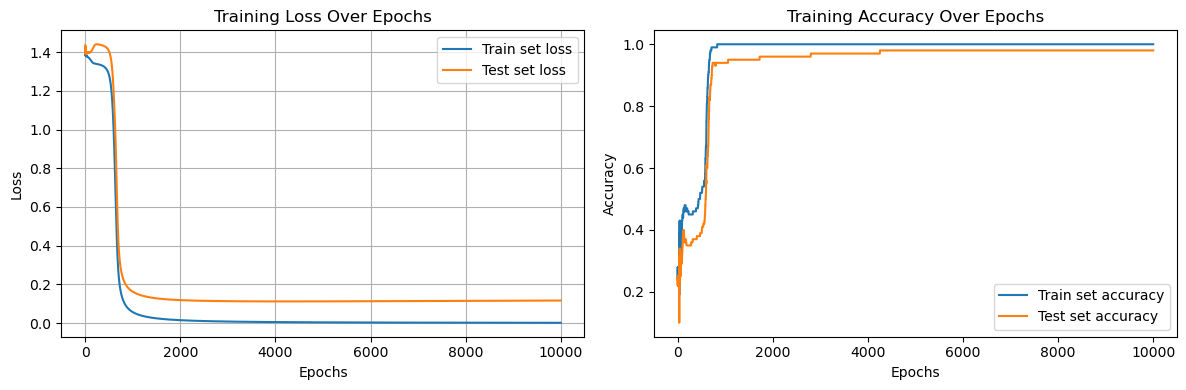

In [8]:
hidden_size = 128
num_classes = 4
model = MLPMultiClassClassifier(input_size=num_features, hidden_size=hidden_size, output_size=num_classes).to("cuda")

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=4).to("cuda")

num_epochs = 10000
epochs = []
losses_train = []
losses_test = []
acc_train = []
acc_test = []
for epoch in range(num_epochs):
    model.train()

    # forward and back propagation on train
    logits = model(x_train)
    loss = loss_function(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute train loss and acc
    train_loss = loss.item()
    predicted_classes = torch.argmax(logits, dim=1)
    train_acc = accuracy_metric(predicted_classes, y_train)

    # compute test loss and acc
    logits = model(x_test)
    test_loss = loss_function(logits, y_test).item()
    predicted_classes = torch.argmax(logits, dim=1)
    test_acc = accuracy_metric(predicted_classes, y_test)

    if epoch % 1000 == 999:
        print('Epoch {}/{}, loss: {:.4f}, acc train (%): {:.2f}'.format(epoch+1, num_epochs, train_loss, train_acc*100))

    epochs.append(epoch)
    losses_train.append(train_loss)
    acc_train.append(train_acc.to("cpu"))
    acc_test.append(test_acc.to("cpu"))
    losses_test.append(test_loss)

plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test)

## Early Stopping

To navigate between **underfitting due to training with too few epochs** and **overfitting due to training with too many epochs**, we can set up a larger value for `n_epochs` and use early stopping in our training codes to handle it.

To implement early stopping, we need to:
- Track the changes of `test_loss`. If it keeps dropping, we will keep on training the model.
- Set up a `patience`. When `test_loss` doesn't drop for over `patience` epochs, stop training the model.
- Save the best model parameters (`model.state_dict()`).

Epoch 1000/10000, loss: 0.0653, acc train (%): 100.00
Epoch 2000/10000, loss: 0.0160, acc train (%): 100.00
Epoch 3000/10000, loss: 0.0081, acc train (%): 100.00
Epoch 4000/10000, loss: 0.0051, acc train (%): 100.00
Early stopping triggered at epoch 4008


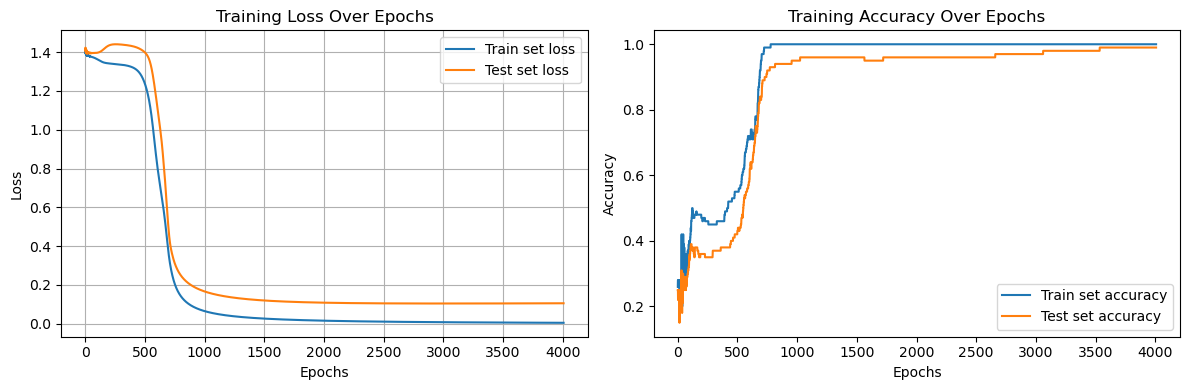


 The best model test accuracy: 0.97%


In [9]:
hidden_size = 128
num_classes = 4
model = MLPMultiClassClassifier(input_size=num_features, hidden_size=hidden_size, output_size=num_classes).to("cuda")

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=4).to("cuda")

# -- Early Stopping Setup --
import copy
patience = 1000
best_test_loss = float('inf') # Track the best test loss so far
best_model_weights = copy.deepcopy(model.state_dict())  # To store the best model weights
no_improvement_count = 0

# Start training
num_epochs = 10000
epochs = []
losses_train = []
losses_test = []
acc_train = []
acc_test = []
for epoch in range(num_epochs):
    model.train()
    logits = model(x_train)
    loss = loss_function(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    predicted_classes = torch.argmax(logits, dim=1)
    epoch_accuracy = accuracy_metric(predicted_classes, y_train)

    logits = model(x_test)
    loss_test = loss_function(logits, y_test)
    predicted_classes = torch.argmax(logits, dim=1)
    test_score = accuracy_metric(predicted_classes, y_test)

    if epoch % 1000 == 999:
        print('Epoch {}/{}, loss: {:.4f}, acc train (%): {:.2f}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy*100))

    epochs.append(epoch)
    losses_train.append(epoch_loss)
    acc_train.append(epoch_accuracy.to("cpu"))
    acc_test.append(test_score.to("cpu"))
    losses_test.append(loss_test.item())

    # Early Stopping: update best test loss and check the improvement
    if loss_test < best_test_loss:
        best_test_loss = loss_test
        best_model_weights = copy.deepcopy(model.state_dict()) # save the best model parameters
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

# plot all curves
plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test)

# After training, load the best model weights we saved
model.load_state_dict(best_model_weights)

# Evaluate the best model state on test set
model.eval()
y_pred = model(x_test).to("cuda")
test_accuracy = accuracy_metric(y_pred, y_test)
print('\n The best model test accuracy: {:.2f}%'.format(test_accuracy))

### Checkpoint Reading and Writing

To store model checkpoints, aside from using `copy` to save them as **variables**, you can also save the parameters to your local directory. See [these examples](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for reading and writing a checkpoint. Writing a model checkpoint can take a long time, so for early stopping, we don't recommend saving models **every epoch**. Instead, you can set up a cycle that periodically saves a checkpoint to your computer. This also guarantees that you don't need to retrain a model when there's accidental stops of your program.

On Colab, however, you will not be saving the model to your computer. You will need to connect the script to **Google Drive**:
```
from google.colab import drive
drive.mount('/content/drive')
```
To point to your Google Drive directories, use the following path:
```
google_drive_path = '/content/drive/My Drive/...'
```
Now, let's try to run the following cell to connect your Google Drive path! When the sign in page pops out, click on "Connect to Google Drive" and select the accesses that apply.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Write a model checkpoint:**

In [10]:
model_path = 'demo_model.pth'
torch.save(model.state_dict(), model_path)

**Read a model checkpoint:**

Calculate the test accuracy again to see if this is the correct model.

In [11]:
hidden_size = 128
num_classes = 4
model = MLPMultiClassClassifier(input_size=num_features, hidden_size=hidden_size, output_size=num_classes).to("cuda")

model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
y_pred = model(x_test).to("cuda")
test_accuracy = accuracy_metric(y_pred, y_test)
print('The best model test accuracy: {:.2f}%'.format(test_accuracy))

The best model test accuracy: 0.97%


## L2 Regularization

The simplest way to add L2 regularization is through the builtin setup of the optimizer. In [`optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), the argument `weight_decay` helps adding the penalty of L2. The larger the value is, the more penalty is applied to your loss.

Optionally, you can also always add the penalty **manually**, which will be something like this:
```
reg_loss = 0
for param in model.parameters():
    reg_loss += torch.sum(param**2)  # or param.norm(2)

# Weighted L2 penalty
lambda_l2 = 1e-4
loss = loss + lambda_l2 * reg_loss
```

We can see that the L2 loss helps control the overfitting trend by observing the changes in test loss.

Epoch 1000/10000, loss: 1.3451, acc train (%): 47.00
Epoch 2000/10000, loss: 0.7750, acc train (%): 51.00
Epoch 3000/10000, loss: 0.6016, acc train (%): 75.00
Epoch 4000/10000, loss: 0.1890, acc train (%): 100.00
Epoch 5000/10000, loss: 0.1876, acc train (%): 100.00
Epoch 6000/10000, loss: 0.1865, acc train (%): 100.00
Epoch 7000/10000, loss: 0.1852, acc train (%): 100.00
Epoch 8000/10000, loss: 0.1846, acc train (%): 100.00
Epoch 9000/10000, loss: 0.1844, acc train (%): 100.00
Epoch 10000/10000, loss: 0.1843, acc train (%): 100.00


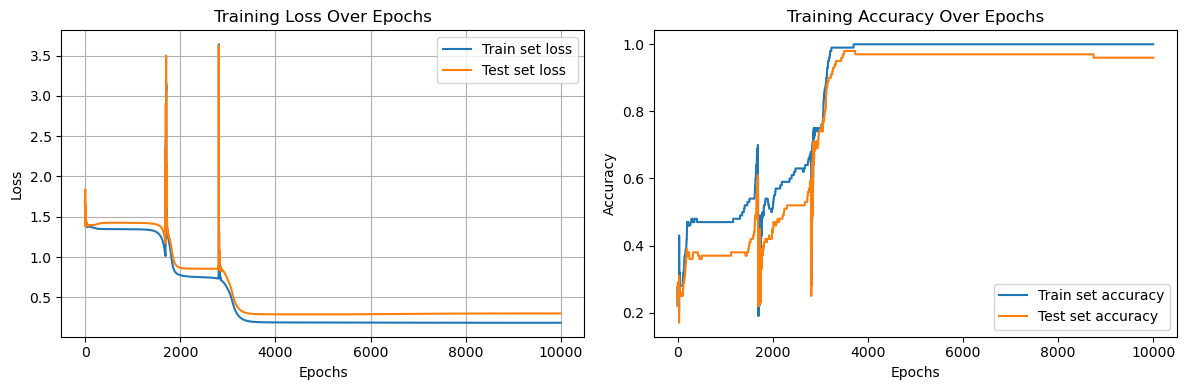


 The best model test accuracy: 97.00%


In [12]:
hidden_size = 128
num_classes = 4
model = MLPMultiClassClassifier(input_size=num_features, hidden_size=hidden_size, output_size=num_classes).to("cuda")

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=1e-3)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=4).to("cuda")

# Start training
num_epochs = 10000
epochs = []
losses_train = []
losses_test = []
acc_train = []
acc_test = []
for epoch in range(num_epochs):
    model.train()
    logits = model(x_train)
    loss = loss_function(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    predicted_classes = torch.argmax(logits, dim=1)
    epoch_accuracy = accuracy_metric(predicted_classes, y_train)

    logits = model(x_test)
    loss_test = loss_function(logits, y_test)
    predicted_classes = torch.argmax(logits, dim=1)
    test_score = accuracy_metric(predicted_classes, y_test)

    if epoch % 1000 == 999:
        print('Epoch {}/{}, loss: {:.4f}, acc train (%): {:.2f}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy*100))

    epochs.append(epoch)
    losses_train.append(epoch_loss)
    acc_train.append(epoch_accuracy.to("cpu"))
    acc_test.append(test_score.to("cpu"))
    losses_test.append(loss_test.item())

# plot all curves
plot_loss_acc(epochs, losses_train, losses_test, acc_train, acc_test)

# After training, load the best model weights we saved
model.load_state_dict(best_model_weights)

# Evaluate the best model state on test set
model.eval()
y_pred = model(x_test)
test_accuracy = accuracy_metric(y_pred, y_test)
print('\n The best model test accuracy: {:.2f}%'.format(test_accuracy*100))

## Review

Underfitting and overfitting are common training issues. Learning how to identify different model issues and causes can increase your efficiency.

Here are some practices that you can try:
1. **Increase the model depth**: train models with (1) 5 layers and 2 nodes per layer, and (2) 5 layers and 128 nodes per layer. What do you see in the trends of these two models? Do you see overfitting or underfitting?
2. **Increase L2 loss**: train models with the optimizer that has (1) `weight_decay=1e-2` and (2) `weight_decay=1e-1`. We know that when the applied L2 loss is too large, it could lead to model underfitting. Do you see that trend in your experiments?



For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :) See you in the next tutorial!

\- Everley